## Q4: Coding Problem

Generated raw data with shape: (240, 5)

--- Part 1: Data Inspection and Pre-processing ---
Visualizing raw data to identify bias...


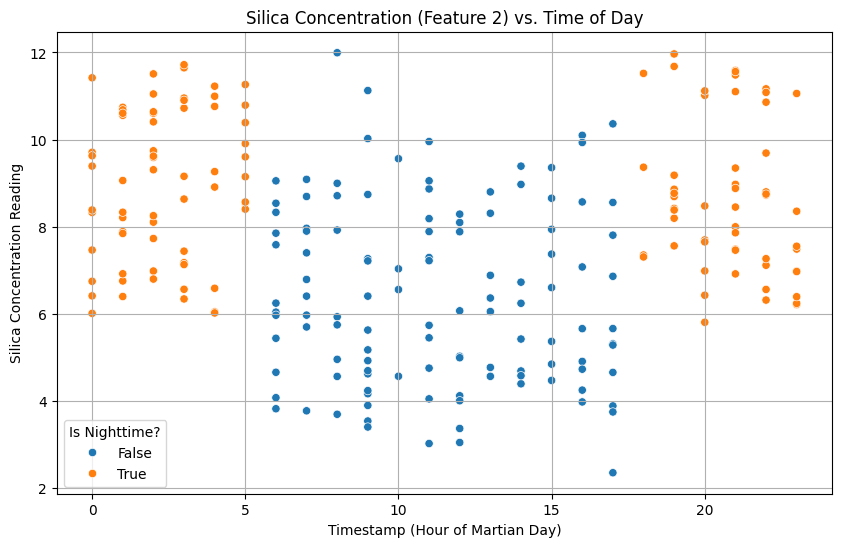

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# --- Data Generation ---
# This function is provided for you. Do not modify it.
def generate_mars_data():
    """
    Generates a synthetic Mars rover dataset.

    - 3 true Gaussian clusters (rock types).
    - Feature at index 2 (silica) is biased upwards by +2.5 for
      readings taken at night (18:00-06:00).
    - ~5% of the data are random outliers from ChemCam "misfires".

    Returns:
        tuple: (data, timestamps)
               - data (np.ndarray): A (250, 5) numpy array.
               - timestamps (np.ndarray): A (250,) array of hours (0-23).
    """
    np.random.seed(42)

    # Define the true clusters
    means = [
        [5.1, 3.5, 4.4, 1.2, 1.1], # Igneous
        [8.5, 3.0, 8.5, 3.8, 2.3], # Sedimentary
        [6.8, 2.7, 6.1, 2.2, 1.5]  # Altered by Water
    ]
    covs = [
        np.diag([0.3, 0.4, 0.5, 0.3, 0.2]),
        np.diag([0.5, 0.3, 0.6, 0.4, 0.4]),
        np.diag([0.4, 0.3, 0.5, 0.3, 0.3])
    ]

    n_samples_per_cluster = 75

    # Generate true data
    true_data = np.vstack([np.random.multivariate_normal(m, c, n_samples_per_cluster) for m, c in zip(means, covs)])

    # Add outliers
    n_outliers = 15
    outliers = np.random.uniform(low=0, high=12, size=(n_outliers, 5))

    # Combine true data and outliers
    data = np.vstack([true_data, outliers])

    # Generate timestamps and apply conditional bias
    n_total = data.shape[0]
    timestamps = np.random.randint(0, 24, n_total)

    # Apply bias to silica reading (feature 2) for nighttime readings
    night_mask = (timestamps >= 18) | (timestamps < 6)
    data[night_mask, 2] += 2.5 # Additive bias

    # Shuffle everything
    shuffle_idx = np.random.permutation(n_total)
    data = data[shuffle_idx]
    timestamps = timestamps[shuffle_idx]

    return data, timestamps


raw_data, timestamps = generate_mars_data()
print(f"Generated raw data with shape: {raw_data.shape}")

print("\n--- Part 1: Data Inspection and Pre-processing ---")

# Part 1 - Task 1: Generate and Inspect the Data (provided for you)
print("Visualizing raw data to identify bias...")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=timestamps, y=raw_data[:, 2], hue=(timestamps >= 18) | (timestamps < 6))
plt.title("Silica Concentration (Feature 2) vs. Time of Day")
plt.xlabel("Timestamp (Hour of Martian Day)")
plt.ylabel("Silica Concentration Reading")
plt.legend(title="Is Nighttime?")
plt.grid(True)
plt.show()


In [118]:
# Part 1 - Task 2: Correct for Systematic Bias (5 points)
df_silicon = pd.DataFrame({
    'Timestamp': timestamps,
    'Silica': raw_data[:, 2]
})
df_silicon.sort_values(by='Timestamp', inplace=True)
df_silicon_day = df_silicon[(df_silicon['Timestamp'] >= 6) & (df_silicon['Timestamp'] < 18)]
df_silicon_night = df_silicon[(df_silicon['Timestamp'] >= 18) | (df_silicon['Timestamp'] < 6)]

df_silicon_day_mean = df_silicon_day['Silica'].mean()
df_silicon_night_mean = df_silicon_night['Silica'].mean()

print(f"Daytime Silica Mean: {df_silicon_day_mean:.2f}")
print(f"Nighttime Silica Mean: {df_silicon_night_mean:.2f}")

Daytime Silica Mean: 6.41
Nighttime Silica Mean: 8.84


#### **The correction bias = Nighttime Silica Mean - Daytime Silica Mean** 

After obtaining the correction bias, we subtract the correction bias from every data point at night

Visualizing corrected data...


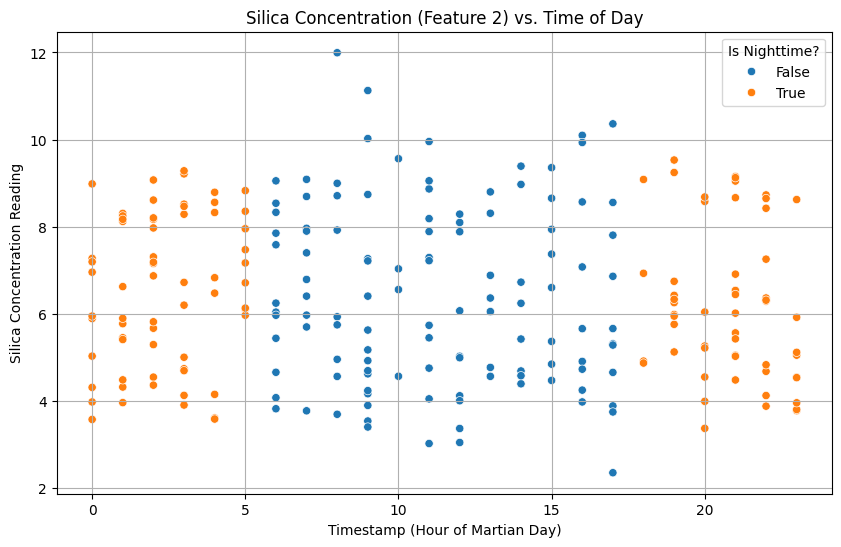

In [119]:
correction_bias = df_silicon_night_mean - df_silicon_day_mean

indices_night = np.where((timestamps >= 18) | (timestamps < 6))

for index in indices_night[0]:
    raw_data[index, 2] = raw_data[index, 2] - correction_bias

corrected_data = raw_data

print("Visualizing corrected data...")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=timestamps, y=raw_data[:, 2], hue=(timestamps >= 18) | (timestamps < 6))
plt.title("Silica Concentration (Feature 2) vs. Time of Day")
plt.xlabel("Timestamp (Hour of Martian Day)")
plt.ylabel("Silica Concentration Reading")
plt.legend(title="Is Nighttime?")
plt.grid(True)
plt.show()

In [120]:
print(correction_bias)

2.4359761102682764


In [121]:


# --- Part 2: Robust Mixture Model from Scratch (25 Points) ---
print("\n--- Part 2: Robust Mixture Model from Scratch ---")

class RobustMixtureModel:
    def __init__(self, n_gaussians=3, n_iter=100):
        self.n_gaussians = n_gaussians
        self.n_components = n_gaussians + 1 # +1 for the uniform outlier model
        self.n_iter = n_iter


    def _e_step(self, X):
        # Calculate likelihoods for each component
        likelihoods = np.zeros((X.shape[0], self.n_components))

        # Gaussian components
        for k in range(self.n_gaussians):
            dist = multivariate_normal(self.means[k], self.covs[k], allow_singular=True)
            likelihoods[:, k] = dist.pdf(X)

        # Uniform component
        likelihoods[:, self.n_gaussians] = self.uniform_density

        # Calculate responsibilities
        numerator = likelihoods * self.weights
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        # Add a small epsilon to denominator to avoid division by zero
        responsibilities = numerator / (denominator + 1e-9)
        return responsibilities

    def _m_step(self, X, responsibilities):


        # Part 2 - Task 2: implementing the update step (15 points)
        responsibilities = self._e_step(X)
        
        for k in range(responsibilities.shape[1]):
            Nk = responsibilities[:, k].sum()
            Nk_ave = Nk / responsibilities.shape[0]
            
            self.weights[k] = Nk_ave
            
            if k < self.n_gaussians:
                gamma_k = responsibilities[:, k][:, np.newaxis] 
                weighted_sum_of_data = np.sum(gamma_k * X, axis=0)
                self.means[k] = weighted_sum_of_data / Nk
                
                diff = X - self.means[k]
                weighted_diff = gamma_k * diff 
                
                self.covs[k] = np.dot(weighted_diff.T, diff) / Nk
            else:
                Nk_uniform = responsibilities[:, k].sum()
                self.weights[k] = Nk_uniform / responsibilities.shape[0]
                    
                

    def fit(self, X):
        n_samples, n_features = X.shape

        # Part 2 - Task 3: performe the main training loop (10 points)

        # Initialize parameters
        # Gaussian params
        self.means = X[np.random.choice(n_samples, self.n_gaussians, replace=False)]
        self.covs = [
            np.identity(n_features)*1.01 for _ in range(self.n_gaussians)
        ]

        # All weights (Gaussians + Uniform)
        self.weights = np.ones(self.n_components) / self.n_components

        # Uniform outlier model parameter
        data_min =  [np.min(X[:,i]) for i in range(n_features)]
        data_max =  [np.max(X[:, i]) for i in range(n_features)]
        range_x = np.subtract(data_max, data_min)
        self.uniform_density =  1 / np.prod(range_x)


        # 2. Iterative loop
        for i in range(self.n_iter):
          # __TODO__: performe the main training loop
          # __code below__
          responsibilities = self._e_step(X)
          self._m_step(X, responsibilities)



    def predict(self, X):
        responsibilities = self._e_step(X)
        return np.argmax(responsibilities, axis=1)


# Train your robust model
corrected_data = np.array(raw_data)
my_model = RobustMixtureModel(n_gaussians=3, n_iter=100)
my_model.fit(corrected_data)
my_model_labels = my_model.predict(corrected_data)
print("Custom robust mixture model trained.")


--- Part 2: Robust Mixture Model from Scratch ---
Custom robust mixture model trained.



--- Part 3: PCA Visualization ---


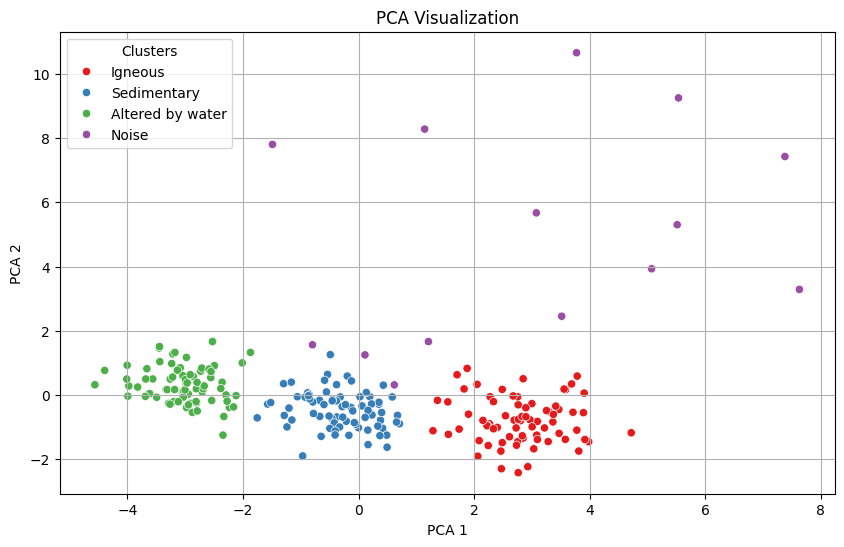

In [122]:


# --- Part 3: Visualization with PCA (5 Points) ---
print("\n--- Part 3: PCA Visualization ---")

pca = PCA(n_components=2)

df = pd.DataFrame(raw_data)
df.columns = [f'Feature {i+1}' for i in range(df.shape[1])]

pca_x = pca.fit_transform(df)

df_pca = pd.DataFrame(pca_x)
df_pca.columns = [f'PCA {i + 1}' for i in range(df_pca.shape[1])]

df_pca['cluster'] = my_model_labels

plt.figure(figsize=(10, 6))

plt.title("PCA Visualization")
sns.scatterplot(x=df_pca['PCA 1'], y=df_pca['PCA 2'], hue= df_pca['cluster'], palette="Set1")

handles, current_labels = plt.gca().get_legend_handles_labels()

custom_labels = ["Igneous", "Sedimentary", "Altered by water", "Noise"] 

plt.legend(
    handles=handles,
    labels=custom_labels,
    title='Clusters',
    loc='best'
)

plt.grid()

plt.show()


#### The plot labels were arbitrarily selected for purposes of visualization alone.In unsupervised learning, we do not have data labels.

In [123]:
df_pca_kmeans = pd.DataFrame(pca_x)
df_pca_kmeans.columns = [f'PCA {i + 1}' for i in range(df_pca_kmeans.shape[1])]


df_pca_gmm = pd.DataFrame(pca_x)
df_pca_gmm.columns = [f'PCA {i + 1}' for i in range(df_pca_gmm.shape[1])]

df_pca_gmm.head()

,PCA 1,PCA 2
0,4.719121,-1.177510
1,-1.490463,7.804761
2,3.025946,-0.855738
3,-3.439359,1.037453
4,-3.054058,0.119214



--- Part 4: Comparison and Discussion ---


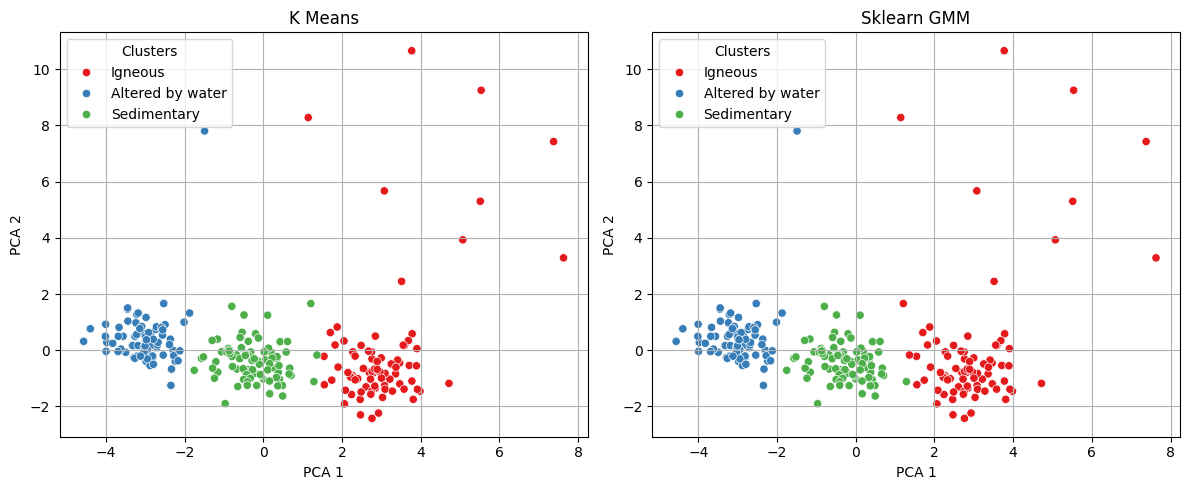

In [124]:


# --- Part 4: Comparison and Discussion (25 Points) ---
print("\n--- Part 4: Comparison and Discussion ---")

# Train scikit-learn GMM with 3 components
gmm = GaussianMixture(n_components=3, random_state=20)
gmm.fit(df)
cluster_labels = gmm.predict(df)
df_pca_gmm['cluster'] = cluster_labels

# Train KMeans with 3 clusters
k = KMeans(n_clusters = 3, random_state=20)
cluster_predicted = k.fit_predict(df)
df_pca_kmeans['cluster'] = cluster_predicted
# Visualize sklearn GMM results

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.scatterplot(x=df_pca_kmeans['PCA 1'], y=df_pca_kmeans['PCA 2'], hue= df_pca_kmeans['cluster'], palette="Set1", ax=axes[0])
axes[0].set_title('K Means')

sns.scatterplot(x=df_pca_gmm['PCA 1'], y=df_pca_gmm['PCA 2'], hue= df_pca_gmm['cluster'], palette="Set1", ax=axes[1])
axes[1].set_title('Sklearn GMM')

handles, current_labels = plt.gca().get_legend_handles_labels()

custom_labels = ["Igneous", "Altered by water","Sedimentary"] 

axes[0].legend(
    handles=handles,
    labels=custom_labels,
    title='Clusters',
    loc='best'
)

axes[1].legend(
    handles=handles,
    labels=custom_labels,
    title='Clusters',
    loc='best'
)

plt.tight_layout()
axes[0].grid()
axes[1].grid()

plt.show()

# Visualize KMeans results


### Discussion


.


.

#### 1. PCA Model comparison 

.


My model's PCA plot was able to successfully cluster the data points into 4 categories with      there being a clear distinction between the different regions in the cluster.
My model's PCA plot also did not wongfully cluster a data point into one cluster when the data point infact was closer to a different cluster. This wrongful clustering was evident in the standard models' PCA plots. However, the noise cluster in my model's PCA plot clustered some of the data points from the "Sedimentary" cluster as it's own. This could potentially be due to the fact that the random noise cluster has a highrt variance hence the algorithm's clustering radius for that cluster is much larger.

The standard model PCA plots clustered the random noise data points into the nearest cluster group. 

Something worth noting was that the standard model clusters were dependent on the random state. when the random state was changed the outcome of the PCA plots was different. 


#### 2. Advantages of outlier modelling 
Explicitly modelling oulier data points tends to improve clustering accuracy because when a clustering model has to cluster each data point and there are outliers in the data points, the algorithm will be forced to expand its clustering borders wider to accomodate the outliers which will in turn lead to the increase in the probability of overlap of clusters which results in inaccurate clusters.

Algorithms that explicitly model outlier data points are more robust, meaning that they are not easily affected by outlier data points.


#### 3. limitations of the uniform outlier model

Uniform outlier models make the assumption that data is linearly and evenly distributed which does not mimic real world data and leads to misclassification of both normal data points and outlier data points.

In [125]:
# --- Bonus part below

In [126]:
class PCA:
    def __init__(self, n_dimensions):
        self.n_dimensions = n_dimensions
        self.n_components = None
        self.components = None
        self.mean = None
        

    def fit(self, X):
        #  Standardize the Data
        self.mean = np.mean(X, axis=0)
        X = X -  self.mean

        # Compute the Covariance Matrix
        cov = np.cov(X.T)

        # Find Eigenvectors and Eigenvalues
        eigenvalues, eigenvectors  = np.linalg.eig(cov)

        #Project the standardized data onto the top two eigenvectors
        eigenvectors = eigenvectors.T
        

        indexes = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[indexes]
        eigenvectors = eigenvectors[:, indexes]

        self.components = eigenvectors[:self.n_dimensions]

    def transform(self, X):
        X = X - self.mean
        return np.dot(X, self.components.T)

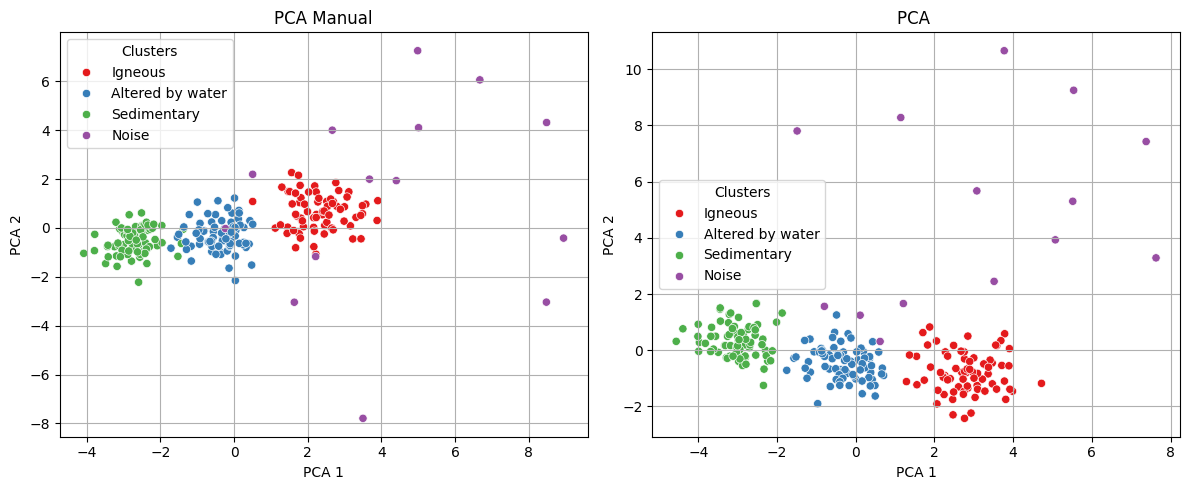

In [127]:
pca_manual = PCA(2)
pca_manual.fit(corrected_data)
pca_transformed = pca_manual.transform(corrected_data)


pca_transformed_df = pd.DataFrame(pca_transformed)
pca_transformed_df.columns = [f'PCA {i+1}' for i in range(pca_transformed_df.shape[1])]
pca_transformed_df['cluster'] = my_model_labels


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.scatterplot(x=pca_transformed_df['PCA 1'], y=pca_transformed_df['PCA 2'], hue= pca_transformed_df['cluster'], palette="Set1", ax=axes[0])
axes[0].set_title('PCA Manual')

sns.scatterplot(x=df_pca['PCA 1'], y=df_pca['PCA 2'], hue= df_pca['cluster'], palette="Set1", ax=axes[1])
axes[1].set_title('PCA ')

handles, current_labels = plt.gca().get_legend_handles_labels()

custom_labels = ["Igneous", "Altered by water","Sedimentary", "Noise"] 

axes[0].legend(
    handles=handles,
    labels=custom_labels,
    title='Clusters',
    loc='best'
)

axes[1].legend(
    handles=handles,
    labels=custom_labels,
    title='Clusters',
    loc='best'
)

plt.tight_layout()
axes[0].grid()
axes[1].grid()

plt.show()



### Comparison

The manually generated PCA plot and the Sklearn PCA plot are different such that they are mirror copies of each other. This could possibly be because Sklearn performs standardization and change of basis of the PCA plot while my function did not change the basis and standardize the plots.